In [1]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 19.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=f79ea5def406b95277968d51ae5a368e8118cd7b6b1186d3a13c27fa8b0b8a96
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=8b56206a9ff866ca7d57986842dd4b6b63b02c3d855e6a10a6a4dc02079432f6
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from random import random, seed
import os
import shutil
from os.path import getsize
import math

from skimage.draw import line, polygon, circle, ellipse

from keras.preprocessing import image
import keras
from keras import layers
from keras import models
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.framework.ops import Tensor
from tensorflow.python.data.ops.dataset_ops import TensorSliceDataset, BatchDataset
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Conv2D, Flatten, Dropout, UpSampling2D
from tensorflow.keras.optimizers import SGD, Adam, Ftrl, Nadam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy

import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, Reshape, Input, Conv2DTranspose
from keras.models import Sequential, Model, load_model

# !pip install umap-learn
# !pip install hdbscan
import hdbscan
import string
import umap

In [ ]:
####################################
# Paths of the contour img files
####################################

root = Path("/content/drive/MyDrive")

models = ["GISS_E2_1_G_ssp245", "GFDL_ESM4_ssp245", "GFDL_ESM4_ssp585", "GISS_E2_1_G_ssp585"]

fig_paths = []
for model in models:
    img_folder = f"shapes/{model}"
    figs = [str(p) for p in (root/img_folder).rglob("*.jpg")]
    figs = [f for f in figs if not "checkpoint" in str(f)]
    figs = [f for f in figs if os.path.getsize(f) > 0]
    print(model, '\t', len(figs), 'jpg files')
    fig_paths += figs

print(f"total {len(fig_paths)} images")

GISS_E2_1_G_ssp245 	 11130 jpg files
GFDL_ESM4_ssp245 	 11282 jpg files
GFDL_ESM4_ssp585 	 11011 jpg files
GISS_E2_1_G_ssp585 	 6603 jpg files
total 40026 images


In [ ]:
####################################
# Read contours meta data
####################################

folder = Path("/content/drive/MyDrive/cmip6")
path = folder/"df_meta.pkl"

models = ["GISS_E2_1_G_ssp245", "GFDL_ESM4_ssp245", "GFDL_ESM4_ssp585", "GISS_E2_1_G_ssp585"]

if path.exists():
    df_meta = pd.read_pickle(path)
else:
    dfs = []
    for model in models:
        jsons = sorted([str(p) for p in (folder/model).rglob("*.json")])
        df = pd.concat([pd.read_json(j) for j in jsons], axis=0)
        df['model'] = model
        dfs.append(df)
    df_meta = pd.concat(dfs, axis=0).reset_index(drop=True)
    df_meta.to_pickle(path)

df = df_meta[(df_meta["type"]=="daily") & (df_meta['area'] > 250)].copy()
df['projected'] = df['projected'].apply(lambda x: np.array(x, dtype=np.float64).squeeze())
df = df[["name", "model", "projected"]]
df.head()

,name,model,projected
0,6c46a5,GISS_E2_1_G_ssp245,"[[295.875, 76.375], [296.125, 76.375], [296.37..."
1,9b94c0,GISS_E2_1_G_ssp245,"[[298.875, 66.625], [298.625, 66.625], [298.37..."
2,2f6756,GISS_E2_1_G_ssp245,"[[276.125, 82.625], [275.375, 82.625], [275.12..."
3,b50daa,GISS_E2_1_G_ssp245,"[[262.875, 31.625], [262.375, 31.625], [262.12..."
4,086c49,GISS_E2_1_G_ssp245,"[[292.375, 83.125], [296.875, 83.125], [297.12..."


In [ ]:
LAT = lat # from xarray attrs
LON = lon

def to_contour(proj:list):
    return [(np.where(LON==r[0])[0][0], 
             np.where(LAT==r[1])[0][0]) for r in proj]

df['contour'] = df['projected'].apply(to_contour)

df.to_pickle(folder/"df_meta_processed.pkl")

In [3]:
folder = Path("/content/drive/MyDrive/cmip6")
df = pd.read_pickle(folder/"df_meta_processed.pkl")
df['contour'] = df['contour'].apply(np.array)
df

,name,model,projected,contour
0,6c46a5,GISS_E2_1_G_ssp245,"[[295.875, 76.375], [296.125, 76.375], [296.37...","[[423, 249], [424, 249], [425, 250], [425, 255..."
1,9b94c0,GISS_E2_1_G_ssp245,"[[298.875, 66.625], [298.625, 66.625], [298.37...","[[435, 210], [434, 210], [433, 209], [433, 208..."
2,2f6756,GISS_E2_1_G_ssp245,"[[276.125, 82.625], [275.375, 82.625], [275.12...","[[344, 274], [341, 274], [340, 273], [337, 273..."
3,b50daa,GISS_E2_1_G_ssp245,"[[262.875, 31.625], [262.375, 31.625], [262.12...","[[291, 70], [289, 70], [288, 69], [276, 69], [..."
4,086c49,GISS_E2_1_G_ssp245,"[[292.375, 83.125], [296.875, 83.125], [297.12...","[[409, 276], [427, 276], [428, 275], [428, 274..."
...,...,...,...,...
181698,afeaa5,GISS_E2_1_G_ssp585,"[[258.125, 39.375], [257.875, 39.125], [257.87...","[[272, 101], [271, 100], [271, 98], [270, 97],..."
181699,d0a665,GISS_E2_1_G_ssp585,"[[260.375, 25.125], [260.375, 26.375], [259.87...","[[281, 44], [281, 49], [279, 51], [279, 52], [..."
181711,0e38af,GISS_E2_1_G_ssp585,"[[295.625, 76.375], [296.125, 76.875], [296.12...","[[422, 249], [424, 251], [424, 252], [425, 253..."
181712,11e001,GISS_E2_1_G_ssp585,"[[295.875, 65.625], [293.125, 65.625], [292.87...","[[423, 206], [412, 206], [411, 205], [410, 205..."


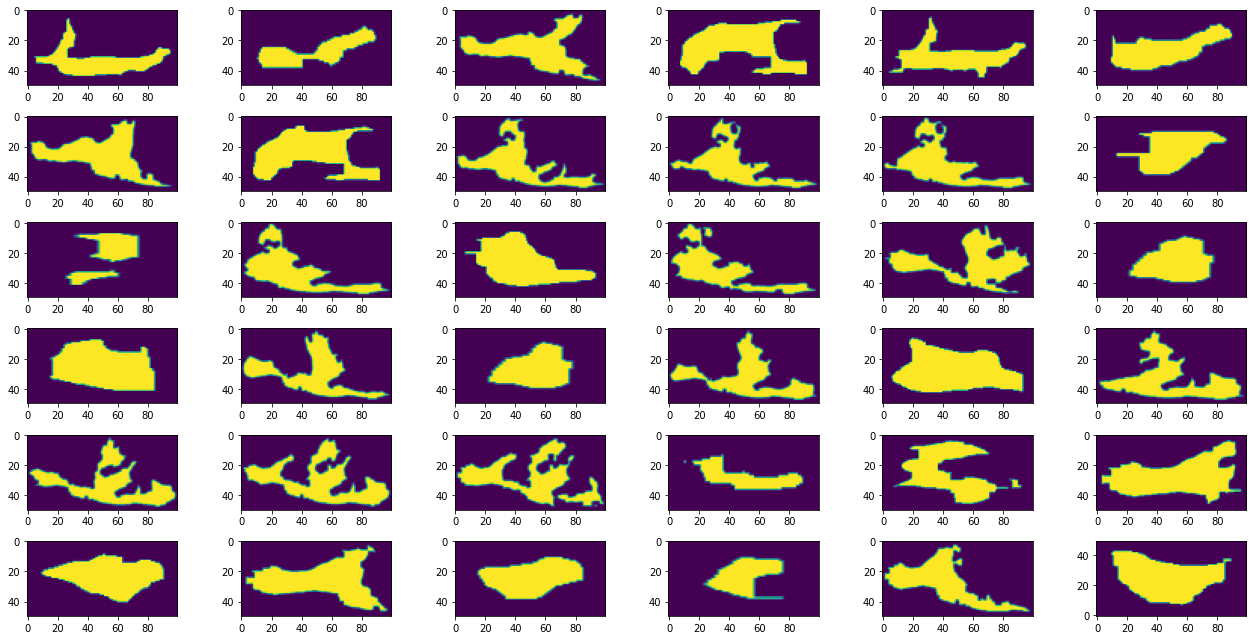

In [129]:
####################################
# Generate a test image for inspection
####################################

from skimage.draw import polygon
from skimage.transform import resize

fig, axs = plt.subplots(6,6, figsize=(18,9))

for i in range(36):

    img = np.zeros((284, 644, 3), np.int32)
    poly = df['contour'].iloc[i]
    rr, cc = polygon(poly[:,1], poly[:,0], img.shape)
    img[rr,cc,0] = 255

    x = poly[:,0]
    y = poly[:,1]

    img = img[y.min():y.max(), x.min():x.max(), :]

    spa = 10
    img = np.pad(img, spa, 'constant', constant_values=0)[:,:,spa:spa+3]

    img = resize(img[:,:,0], (50, 100), anti_aliasing=True)

    ax = axs.ravel()[i]
    ax.imshow(img)
    plt.gca().invert_yaxis()

plt.tight_layout()

In [130]:
####################################
# Convert contours to 2D binary images like above
####################################

from skimage.draw import polygon
from skimage.transform import resize

WIDTH, HEIGHT = 644, 284
WIDTH2, HEIGHT2 = 128, 64

def contour_to_array(poly:np.array)->np.array:
    img = np.zeros((HEIGHT, WIDTH, 1), np.int32)
    rr, cc = polygon(poly[:,1], poly[:,0], img.shape)
    img[rr,cc,:] = 1

    x = poly[:,0]
    y = poly[:,1]

    img = img[y.min():y.max(), x.min():x.max(), :]
    spa = 10
    img = np.pad(img, spa, 'constant', constant_values=0)[:,:,spa:spa+1]
    img = resize(img[:,:,0], (HEIGHT2, WIDTH2), anti_aliasing=True)
    img = img.reshape(img.shape[0], img.shape[1], -1)

    return img

sample_size = 10000
indexes = np.random.choice(range(len(df)), sample_size)
x_train = np.stack(df['contour'].iloc[indexes].apply(contour_to_array).values)
x_train = x_train.astype(np.float32)
labels = df['model'].iloc[indexes]
x_train.shape

(10000, 64, 128, 1)

In [246]:
indexes

array([14462,  7700, 41673, ..., 32022, 14732, 14308])

In [131]:
####################################
# Train Convoluted autoencoder - UMAP
####################################

K.clear_session()

input = Input(shape=(HEIGHT2,WIDTH2,1))

x = Conv2D(16, (3, 3), activation="relu", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Dropout(0.5)(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same", name='encoded')(x)
encoder = Model(input, encoded)

x = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input, decoded)

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                         epochs=10,
                         batch_size=32,
                         verbose=True,)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 16)        2320      
                                                                 
 encoded (MaxPooling2D)      (None, 16, 32, 16)        0         
                                                           

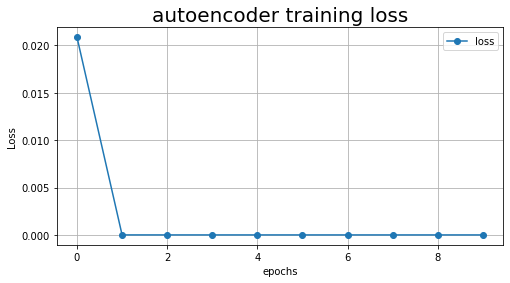

In [132]:
####################################
# Plot training history
####################################

def create_plot(history, title)->None:
  
    x = history.epoch
    y = history.history['loss']

    fig, ax = plt.subplots(1,1, figsize=(8,4))

    ax.plot(x, y, label='loss', marker='o')

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('epochs')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()
    
create_plot(history, "convolutional autoencoder training loss")

In [133]:
####################################
# Create embeddings vector from the encoder
####################################

codings = encoder.predict(x_train)
codings.shape

embeded = codings.reshape(codings.shape[0], codings.shape[1]*codings.shape[2]*codings.shape[3])
embeded.shape

(10000, 8192)

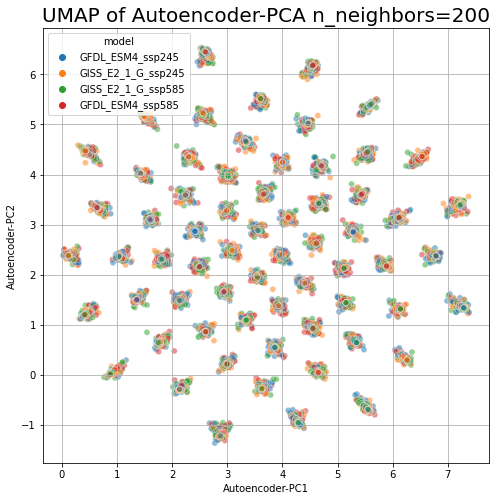

In [137]:
####################################
# UMAP transformation for dimension reduction to 2D
####################################
n_neighbors=200
reducer = umap.UMAP(n_components=2, init='random', n_neighbors=n_neighbors)
proj2d = reducer.fit_transform(embeded)

######################################
# Plot the observations in the plane of the two Principal Components
######################################

fig, ax = plt.subplots(1,1, figsize=(8,8))

sns.scatterplot(x=proj2d[:,0], y=proj2d[:,1], hue=labels, alpha=.5, ax=ax)

ax.set_title(f"UMAP of Autoencoder-PCA n_neighbors={n_neighbors}", fontsize=20)
ax.set_xlabel('Autoencoder-PC1')
ax.set_ylabel('Autoencoder-PC2')
ax.grid(True);

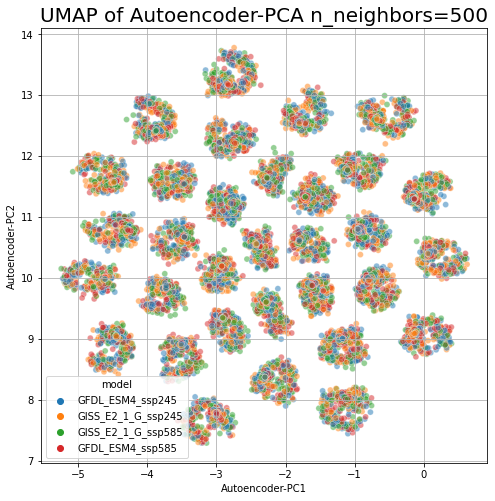

In [138]:
####################################
# UMAP transformation for dimension reduction to 2D
####################################
n_neighbors=500
reducer = umap.UMAP(n_components=2, init='random', n_neighbors=n_neighbors)
proj2d = reducer.fit_transform(embeded)

######################################
# Plot the observations in the plane of the two Principal Components
######################################

fig, ax = plt.subplots(1,1, figsize=(8,8))

sns.scatterplot(x=proj2d[:,0], y=proj2d[:,1], hue=labels, alpha=.5, ax=ax)

ax.set_title(f"UMAP of Autoencoder-PCA n_neighbors={n_neighbors}", fontsize=20)
ax.set_xlabel('Autoencoder-PC1')
ax.set_ylabel('Autoencoder-PC2')
ax.grid(True);

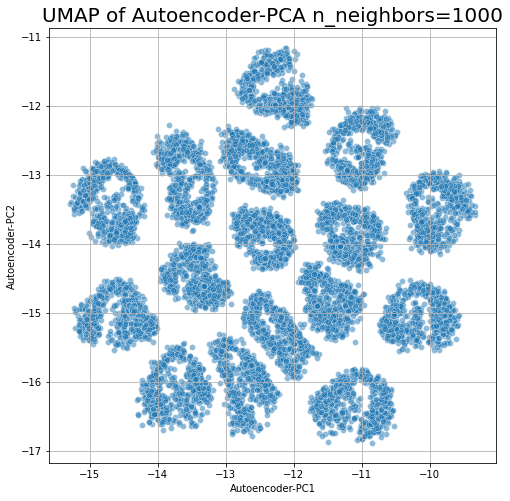

In [227]:
####################################
# UMAP transformation for dimension reduction to 2D
####################################

if (folder/"_proj2d.npy").exists():
    proj2d = np.load(folder/"_proj2d.npy")
else:
    n_neighbors=1000
    reducer = umap.UMAP(n_components=2, init='random', n_neighbors=n_neighbors)
    trans = reducer.fit(embeded[:100])
    proj2d = trans.transform(embeded[:100])
    np.save(folder/"proj2d.npy", proj2d)

######################################
# Plot the observations in the plane of the two Principal Components
######################################

fig, ax = plt.subplots(1,1, figsize=(8,8))

sns.scatterplot(x=proj2d[:,0], y=proj2d[:,1], alpha=.5, ax=ax)

ax.set_title(f"UMAP of Autoencoder-PCA n_neighbors={n_neighbors}", fontsize=20)
ax.set_xlabel('Autoencoder-PC1')
ax.set_ylabel('Autoencoder-PC2')
ax.grid(True); 

4176 4176 4176
[0 1 2]
[1044  646 2486]


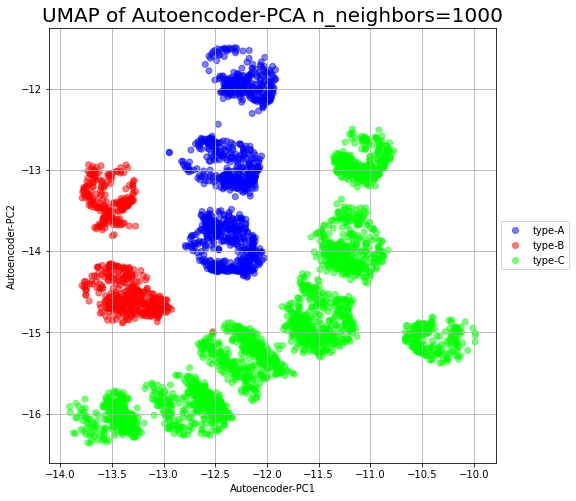

In [308]:
######################################
# Apply HDBSCAN clustering algorithm
######################################

proj2d = np.load(folder/"_proj2d.npy")

clusterlabels = hdbscan.HDBSCAN(
    min_samples=350,
    min_cluster_size=400,
).fit_predict(proj2d)

clustered = clusterlabels >= 0
proj2d = proj2d[clustered]
clusterlabels = clusterlabels[clustered]
contourlabels = df['model'].iloc[indexes][clustered]
clusterarrays = x_train[clustered]

######################################
# Plot the observations in the plane of the two Principal Components
######################################

fig, ax = plt.subplots(1,1, figsize=(8,8))

sct = ax.scatter(x=proj2d[:,0], y=proj2d[:,1], 
                c=clusterlabels, 
                alpha=.5, cmap='brg', )

h,l = sct.legend_elements()
alph = list(string.ascii_uppercase)
l = [f"type-{alph[i]}" for i in range(len(l))]

ax.legend(h, l, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f"UMAP of Autoencoder-PCA n_neighbors={n_neighbors}", fontsize=20)
ax.set_xlabel('Autoencoder-PC1')
ax.set_ylabel('Autoencoder-PC2')
ax.grid(True); 

print(len(clusterlabels), len(contourlabels), len(clusterarrays))
uniques = np.unique(clusterlabels, return_counts=True)
print(uniques[0])
print(uniques[1])

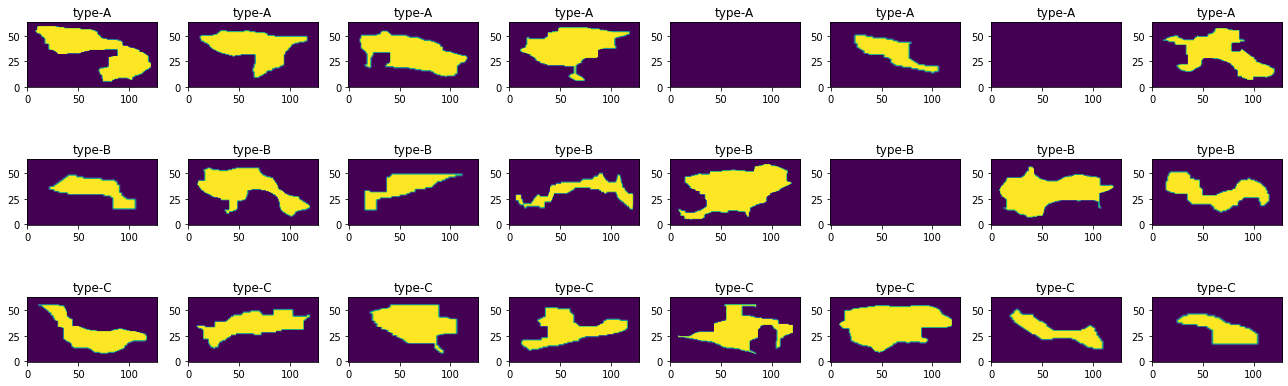

In [316]:
######################################
# Display example images for each cluster
######################################

Ks = np.unique(clusterlabels)

fig, axs = plt.subplots(len(Ks), 8, figsize=(18, len(Ks)*2))

for k in Ks:

    for i in range(8):
        
        j = np.where(clusterlabels==k)[0][i*2]

        img = clusterarrays[j].squeeze()

        ax = axs[k][i]
        ax.imshow(img)
        ax.invert_yaxis()
        ax.set_title(f"type-{alph[k]}")

plt.tight_layout()